# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [7]:
# %matplotlib widget
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel

***
#### Synthetic Parameters
***

Seed: 1824
Original params:  [  0.  45. -90.]


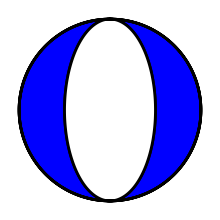

Takeoff angles: [45.74277419944782, 49.94361025435123]


In [8]:
seed = np.random.randint(0, 2025)
# seed = 25
np.random.seed(seed)
print(f'Seed: {seed}')
# np.random.seed(1513)
# np.random.seed(555)

# # BUG plot_iterates_2D (off by 1)
# np.random.seed(560)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)





# t = np.array([ 0.11727534, -0.38461938,  0.91559512])
# t = fn.unit_vec(t)
# p = np.array([-0.31832113,  0.85875371,  0.4015143 ])
# p = fn.unit_vec(p)







# ### NOTE FOR COMPARISON ###
t, p = fn.i_hat, fn.k_hat
# t, p = fn.unit_vec(fn.i_hat + fn.j_hat), fn.unit_vec(fn.j_hat - fn.i_hat)
# t, p = fn.i_hat, fn.j_hat







############################
# USE OBSPY TO PRODUCE BEACHBALLS FROM DIFFERENT INPUT PARAMETERS
# VERIFY CONSISTENCY FOR OUR vs OBSPY FUNCTIONS
############################


# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)


###########################################
# START WITH THIS METADATA, THEN DOUBLE (modular) TODO
# FOCUS ON RANDOMLY CHANGING THEM
# TRY A HANDFUL OF CASES (LEAN TOWARDS PAULA'S DATA)
# ADD OMKAR TO THE PAPER TODO
###########################################



# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
# model = TauPyModel(model='iasp...')
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
p_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P'])
s_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
print(f"Takeoff angles: {takeoff_angles}")


#############################################
# EXTRACT VELOCITIES FROM LOOKUP TABLE
#############################################
# look for them in TauPy, may not work
# use linear interpolation from Suzan's table
#############################################
velocities = np.array([5.8000, 3.4600])

#############################################
# Moment tensor
# Alt cost function --- later
#############################################

***
#### Hybrid Inversion
***

In [9]:
importlib.reload(fn)
importlib.reload(rm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
radiation_model = rm.RadiationModel(np.deg2rad(azimuth), takeoff_angles, velocities)

model_Ao = radiation_model(np.deg2rad(true_params), set_Ao=True, return_A=True)

# tune hyperparameters
config = opt.get_config()

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

# # systematic start for debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_starts = len(starts)

radiation_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model, config, start)
    
print(f'Convergence rate: {radiation_model.get_convergence_rate():.0f}%')

Using sdr parameters.
Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 76%


In [10]:
# this is a good tool for intersection!!!

params, error, position = radiation_model.get_optimal_parameters(z_threshold=2)
name = 'T' if position == 0 else 'P'

print(f'Constrained axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

# plots.half_angles(radiation_model, bins=10)

Constrained axis: P
Optimal parameters: [141.41359817  18.41222918  17.44232776]
Search error: 0.8664296135615113 degrees


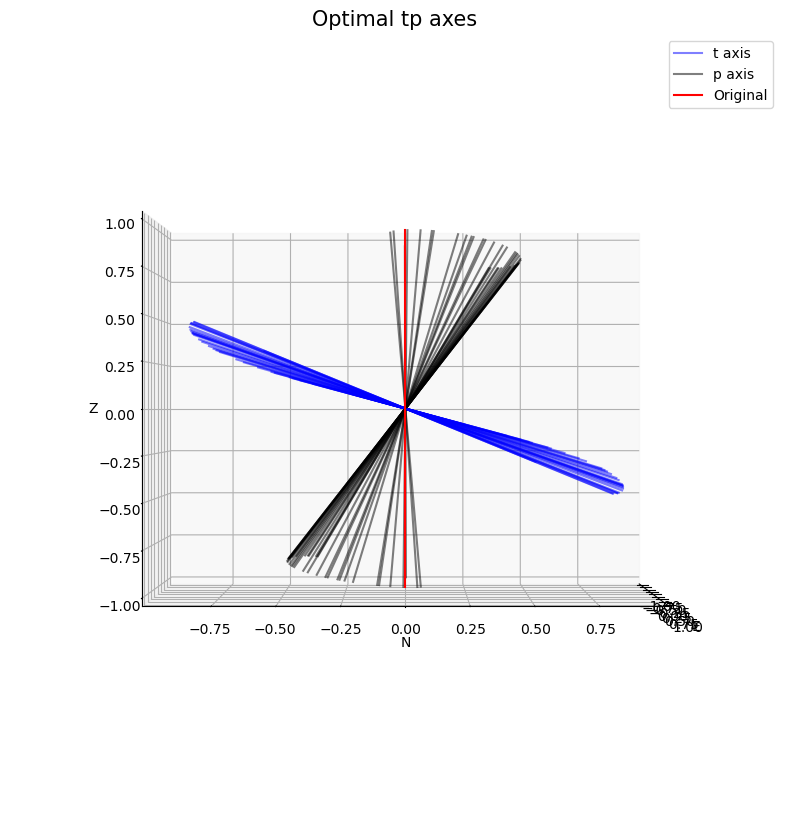

In [11]:
# optimal plot - tp space, collapse to central
importlib.reload(plots)

plots.tp_axes(radiation_model, azim=0, elev=0, half=False)

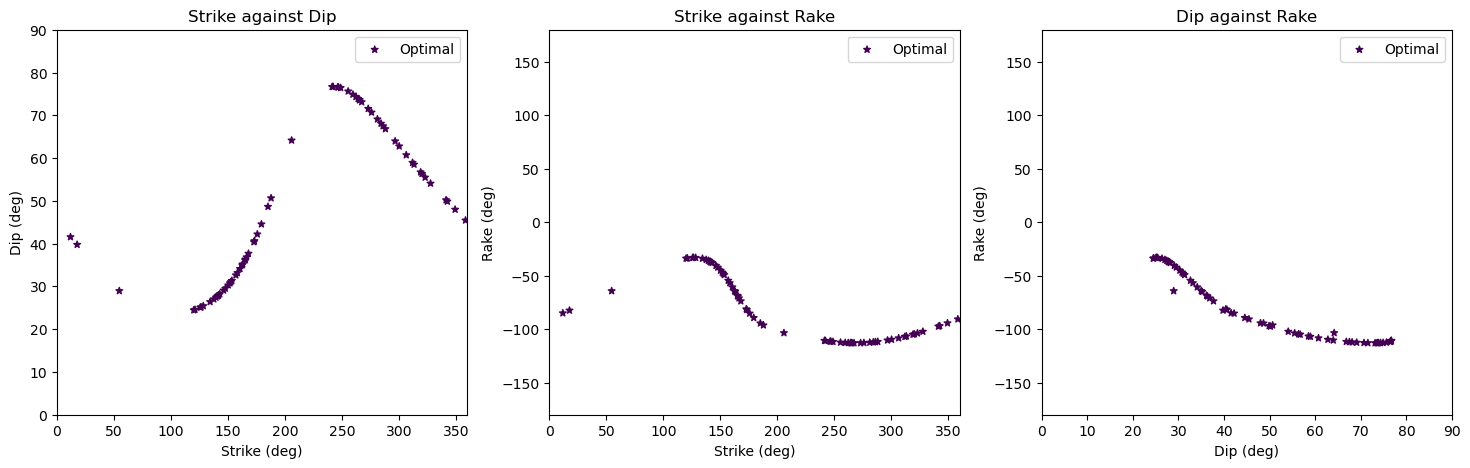

In [12]:
# iterate plot - sdr space
importlib.reload(plots)
plots.iterates_2D(radiation_model, s=25, optimal=True, index=2, cmap='viridis',
                    uncertainty=False)

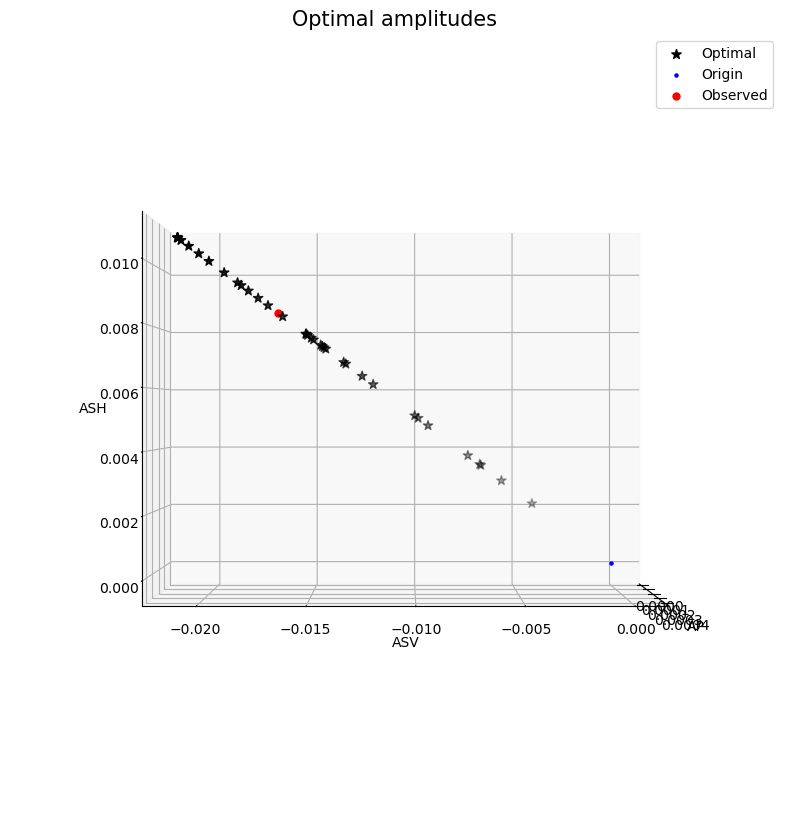

In [178]:
# amplitude plot
importlib.reload(plots)
radiation_model.reset_grid_amplitudes()
radiation_model.set_grid_amplitudes(7, random=False, fix_params=False)
plots.amplitudes(radiation_model, azim=0, elev=-0, s=50, alpha=0.5,
                 iterates=False, grid=False, cross_section=[0,0,0],
                 eps_factor=2e-2, optimal=True, observed=True, cmap='rainbow')

In [179]:
# # amplitude plot
# importlib.reload(plots)
# radiation_model.reset_grid_amplitudes()
# radiation_model.set_grid_amplitudes(3, random=False, fix_params=True)
# plots.amplitudes(radiation_model, azim=200, elev=30, s=50, alpha=0.5,
#                  iterates=True, grid=True, cross_section=[3,3,3],
#                  eps_factor=2e-2, optimal=True, observed=True)

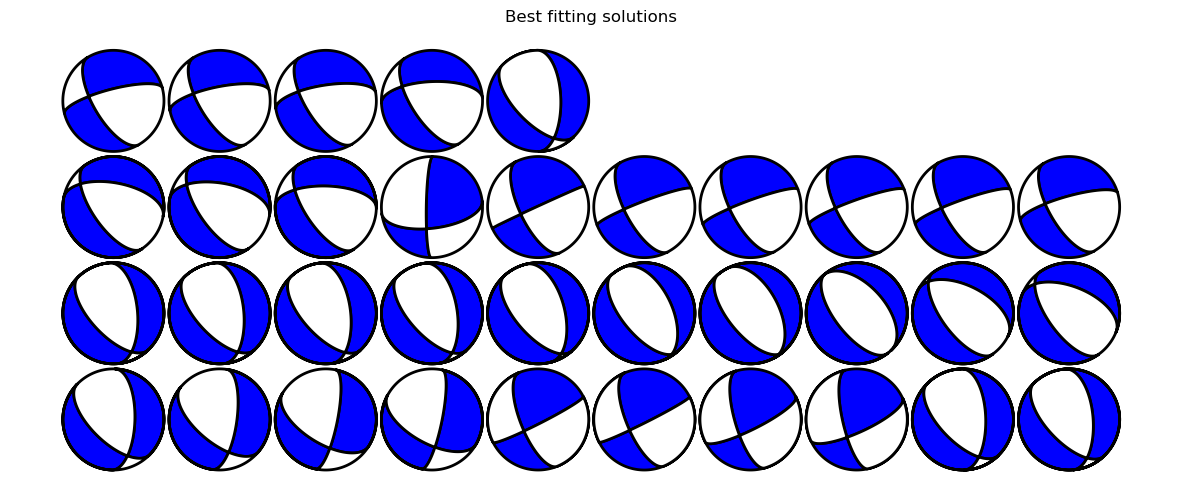

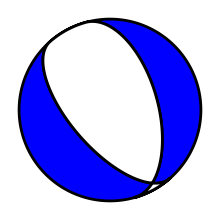

In [180]:
# beachball plots
importlib.reload(plots)
max_plot = max(num_starts, 100)
plots.beachballs(radiation_model, central=False, order_by='strike', max_plot=max_plot,
                 width=10, figsize=(15,10))
beachball

In [11]:
import matplotlib.pyplot as plt
optimal = radiation_model.get_optimal_iterates()
az = radiation_model.get_azimuth()
hidden = [fn.sdr2hidden(params, az=az, in_deg=False) for params in optimal]
tensors = [fn.hidden2mt(params) for params in hidden]

lamb0, lamb1, lamb2 = [], [], []
for tensor in tensors:
    evals, evecs = np.linalg.eig(tensor)
    idx = evals.argsort()[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    lamb0.append(evals[0])
    lamb1.append(evals[1])
    lamb2.append(evals[2])


In [12]:
print(f'Max lamb0: {max(lamb0): .4f}, Min lamb0: {min(lamb0): .4f}, Avg lamb0: {np.mean(lamb0): .4f}')
print(f'Max lamb1: {max(lamb1): .4f}, Min lamb1: {min(lamb1): .4f}, Avg lamb1: {np.mean(lamb1): .4f}')
print(f'Max lamb2: {max(lamb2): .4f}, Min lamb2: {min(lamb2): .4f}, Avg lamb2: {np.mean(lamb2): .4f}')

Max lamb0:  1.0000, Min lamb0:  1.0000, Avg lamb0:  1.0000
Max lamb1:  0.0000, Min lamb1: -0.0000, Avg lamb1: -0.0000
Max lamb2: -1.0000, Min lamb2: -1.0000, Avg lamb2: -1.0000


***
#### Uncertainty Propagation
***

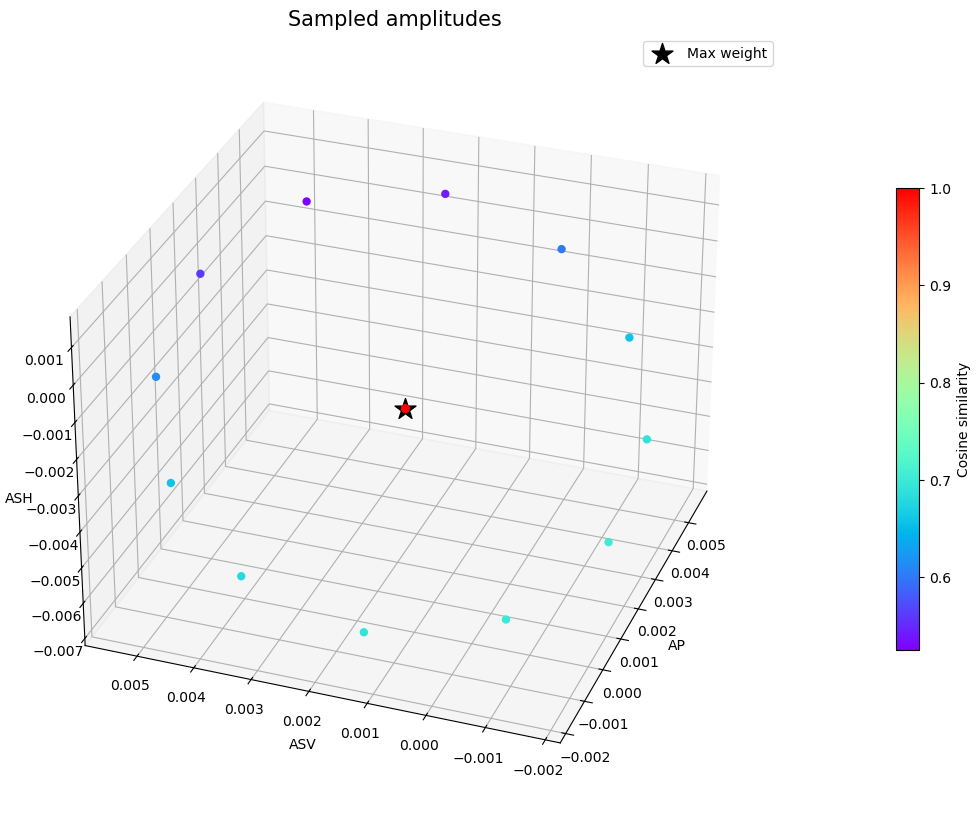

In [84]:
# dd, num_samples = 15, 25
dd, num_samples = 30, 15  # debugging
radiation_model.init_uncertainty()
radiation_model.sample_amplitudes(dd, num_samples)
plots.sampled_amplitudes(radiation_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

In [ ]:
num_runs, print_every = 30, 0
radiation_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 18
Sample 1 of 18
Sample 2 of 18
Sample 3 of 18
Sample 4 of 18
Sample 5 of 18
Sample 6 of 18
Sample 7 of 18
Sample 8 of 18
Sample 9 of 18
Sample 10 of 18
Sample 11 of 18
Sample 12 of 18
Sample 13 of 18
Sample 14 of 18
Sample 15 of 18
Sample 16 of 18
Sample 17 of 18


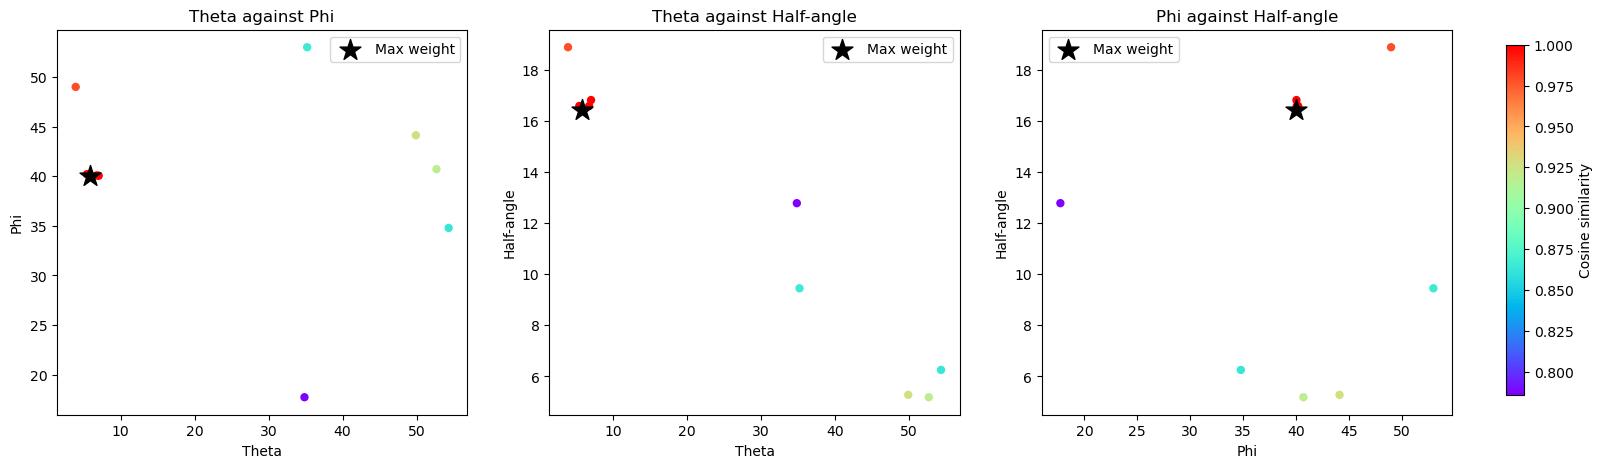

In [ ]:
# monte carlo plot - cone space
error_threshold = 5
radiation_model.post_filter(threshold=error_threshold)
plots.uncertainty_2D(radiation_model, s=25, scale=0)
# plots.uncertainty_3D(elev=30, azim=45, s=25)

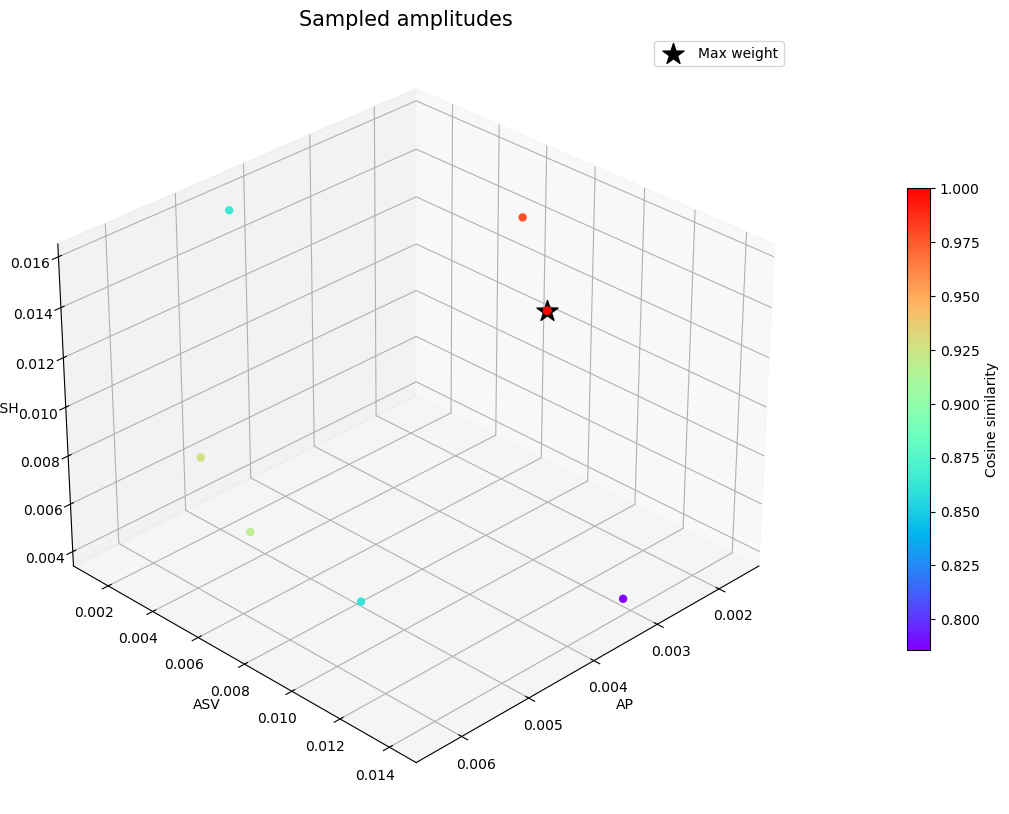

In [ ]:
plots.sampled_amplitudes(radiation_model, cmap='rainbow', s=25)

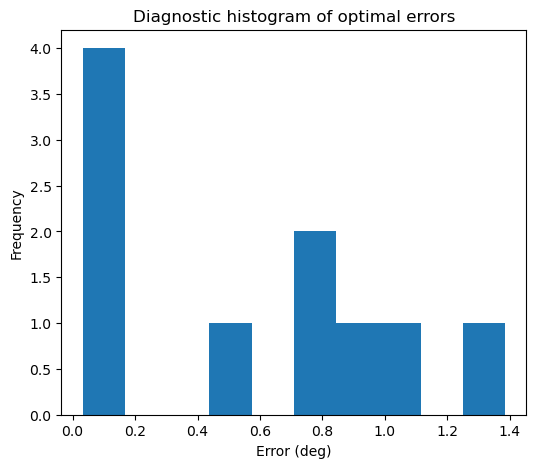

In [ ]:
# diagnostic plot of monte carlo errors
plots.optimal_errors(radiation_model, bins=10)